In [1]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

CLEAN_PATH = "/home/yifan/dataset/resnet18_with_dropout/pairflip/cifar10/0/"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"


ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis'

DEVICE='cuda:0'
########## initulize reference data and target data
from alignment.data_preprocess import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH)
tar_datainit = DataInit(CLEAN_PATH,CLEAN_PATH,TAR_EPOCH)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(mes_val_for_diff=18,mes_val_for_same=0.8,conf_val_for_diff=0.3,conf_val_for_same=0.05)


from representationTrans.trans_visualizer_border import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 477.86it/s]


NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 7934.56it/s]


absolute alignment indicates number: 106 label diff indicates number: 12 confidence diff indicates number: 16 high distance number: 97


In [49]:
X = ref_train_data
Y = tar_train_data

In [47]:
import numpy as np
from scipy.spatial import procrustes
# Perform Procrustes analysis to transform X to Y
mtx1, mtx2, disparity = procrustes(X, Y)
# Compute the transformation degree for each row of the matrix
degree = np.sqrt(np.sum((mtx1 - X)**2, axis=1))

In [86]:
# Find the subset of samples with the highest transformation degree
threshold = np.percentile(degree, 95)
diff_subset = np.where(degree > threshold)[0]

print("Number of samples with highest transformation degree:", len(diff_subset))

Number of samples with highest transformation degree: 2500


In [95]:
from AlignVis.aproximate_ref_generator import ApproximateRefGenerator
aeg = ApproximateRefGenerator(ref_provider=ref_provider, tar_provider=tar_provider, REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH, tar_model=tar_model, ref_model=ref_model,DEVICE=DEVICE)

100%|██████████| 250/250 [00:00<00:00, 8129.63it/s]


In [199]:
newRep = aeg.generate_representation_by_cka(diff_subset, epoch=500)

Iteration 315: CKA loss = 0.0273385644
               Prediction loss = 58.6855545044
               KNN loss = 0.6719999909
              KNN loss with ref = 0.0000000000
               Confidence different loss = 20.3727664948


100%|██████████| 13/13 [00:00<00:00, 13047.61it/s]


Iteration 324: CKA loss = 0.0261293650
               Prediction loss = 60.6602325439
               KNN loss = 0.6713600159
              KNN loss with ref = 0.0000000000
               Confidence different loss = 20.7560272217


100%|██████████| 13/13 [00:00<00:00, 11913.03it/s]


KeyboardInterrupt: 

In [99]:
print('reference predict res: ', ref_prediction_res[diff_subset])
print('adjusetd ref  predict res: ', ref_provider.get_pred(200, newRep).argmax(axis=1))
print('adjusetd ref  predict in tar res: ', tar_provider.get_pred(200, newRep).argmax(axis=1))
print('target        predict res: ', tar_prediction_res[diff_subset])

reference predict res:  [1 7 0 ... 4 8 1]


100%|██████████| 13/13 [00:00<00:00, 11388.04it/s]


adjusetd ref  predict res:  [1 7 0 ... 4 8 1]


100%|██████████| 13/13 [00:00<00:00, 12138.46it/s]

adjusetd ref  predict in tar res:  [5 0 8 ... 7 0 0]
target        predict res:  [1 7 0 ... 4 8 1]


In [101]:
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()

print('CKA between absolute alignmnet subset is:',np_cka.kernel_CKA(newRep,ref_train_data[diff_subset]))

CKA between absolute alignmnet subset is: 0.9956222533647962


In [124]:

print(f"{len(high_distance_indicates)} samples in high prediction MAE set")
in_both_arrays = np.in1d(diff_subset, high_distance_indicates)

print(f"{np.count_nonzero(in_both_arrays)}/{len(high_distance_indicates)} samples of high prediction MAE are present in high_discrepancy_representation_set.")


print(f"{len(absolute_alignment_indicates)} samples in absolute alignmeny set")
in_both_arrays = np.in1d(diff_subset, absolute_alignment_indicates)
print(f"{np.count_nonzero(in_both_arrays)}/{len(absolute_alignment_indicates)} samples of absolute_alignment_indicates are present in high_discrepancy_representation_set.")


print(f"{len(predict_label_diff_indicates)} samples in predict_label_diff set")
in_both_arrays = np.in1d(diff_subset, predict_label_diff_indicates)
print(f"{np.count_nonzero(in_both_arrays)}/{len(predict_label_diff_indicates)} samples of predict_label_diff are present in high_discrepancy_representation_set.")
in_both_arrays = np.in1d(high_distance_indicates, predict_label_diff_indicates)
print(f"{np.count_nonzero(in_both_arrays)}/{len(predict_label_diff_indicates)} samples of predict_label_diff are present in high prediction MAE set.")


97 samples in high prediction MAE set
71/97 samples of high prediction MAE are present in high_discrepancy_representation_set.
106 samples in absolute alignmeny set
3/106 samples of absolute_alignment_indicates are present in high_discrepancy_representation_set.
12 samples in predict_label_diff set
0/12 samples of predict_label_diff are present in high_discrepancy_representation_set.
0/12 samples of predict_label_diff are present in high prediction MAE set.


In [102]:
new_ref_representations = ref_provider.train_representation(200)
for i in range(len(diff_subset)):
    index = diff_subset[i]
    new_ref_representations[index] = newRep[i]

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9613.68it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

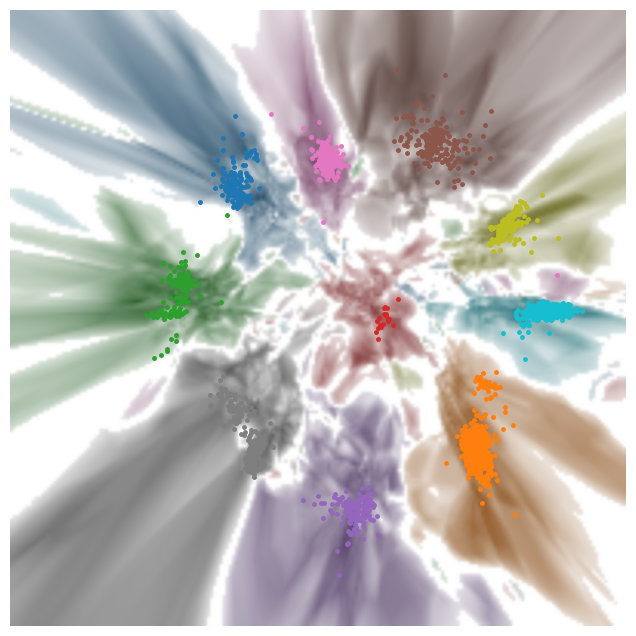

In [198]:
################# validate new_ref_representations visualization result in ref_vis_model  ##############
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis2'

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_train_data, I), projector, 200,[diff_subset],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9640.97it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

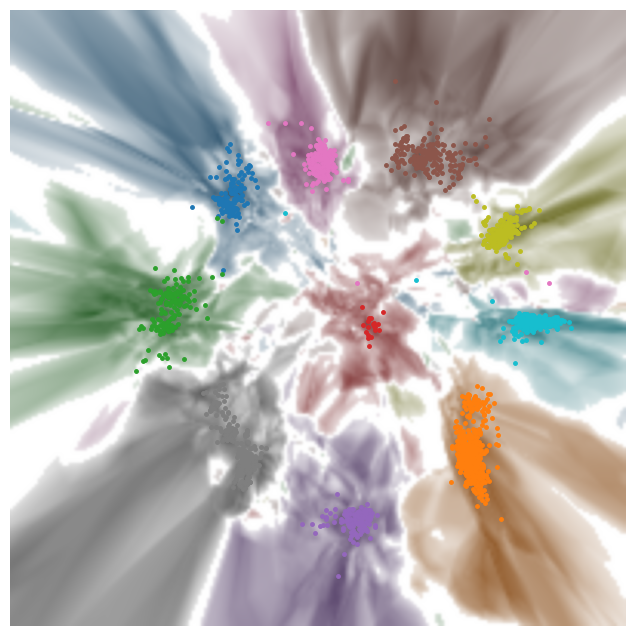

In [197]:
################# validate new_ref_representations visualization result in ref_vis_model  ##############
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis2'

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(new_ref_representations, I), projector, 200,[diff_subset],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

In [125]:
X = new_ref_representations
Y = tar_train_data

In [126]:
from AlignVis.AlignMetrixGenerator import TrainingSnapshotAlignment

alignment_n = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH, projector=projector, visualizer=vis)
R_n = alignment_n.align_embeddings_batch(X,Y,train_steps=1000,CKA_LAMBDA=100,CKA_LAMBAD_FOR_INIT=1e-18,N_LAMBDA=100)

batch_idx 0,iteration 0, loss1 87114472.0 loss2 {tensor(0.8494, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8770, requires_grad=True)}
batch_idx 199,iteration 199, loss1 264.2323913574219 loss2 {tensor(0.5499, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5360, requires_grad=True)}
batch_idx 398,iteration 398, loss1 228.41964721679688 loss2 {tensor(0.4615, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4830, requires_grad=True)}
batch_idx 97,iteration 597, loss1 175.9048614501953 loss2 {tensor(0.4221, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4570, requires_grad=True)}
batch_idx 296,iteration 796, loss1 170.7564239501953 loss2 {tensor(0.3958, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4290, requires_grad=True)}
batch_idx 495,iteration 995, loss1 159.86166381835938 loss2 {tensor(0.3635, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4160, requires_grad=True)}


In [141]:
from AlignVis.AlignMetrixGenerator import TrainingSnapshotAlignment

alignment_n = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH, projector=projector, visualizer=vis)
S_n = alignment_n.align_embeddings_batch(Y,X,train_steps=2000,CKA_LAMBDA=100,CKA_LAMBAD_FOR_INIT=1e-18,N_LAMBDA=100)

batch_idx 0,iteration 0, loss1 65516896.0 loss2 {tensor(0.8280, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8600, requires_grad=True)}
batch_idx 199,iteration 199, loss1 594.8814697265625 loss2 {tensor(0.5508, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5010, requires_grad=True)}
batch_idx 398,iteration 398, loss1 234.2366943359375 loss2 {tensor(0.3651, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4690, requires_grad=True)}
batch_idx 97,iteration 597, loss1 215.57603454589844 loss2 {tensor(0.3312, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4260, requires_grad=True)}
batch_idx 296,iteration 796, loss1 223.56858825683594 loss2 {tensor(0.3464, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4160, requires_grad=True)}
batch_idx 495,iteration 995, loss1 208.26243591308594 loss2 {tensor(0.3047, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.3770, requires_grad=True)}
batch_idx 194,iteration 1194, loss1 186.69549560546875 loss2 {tensor(0.2874, grad_fn=<AddBackward0>)} neibour

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8125.85it/s]


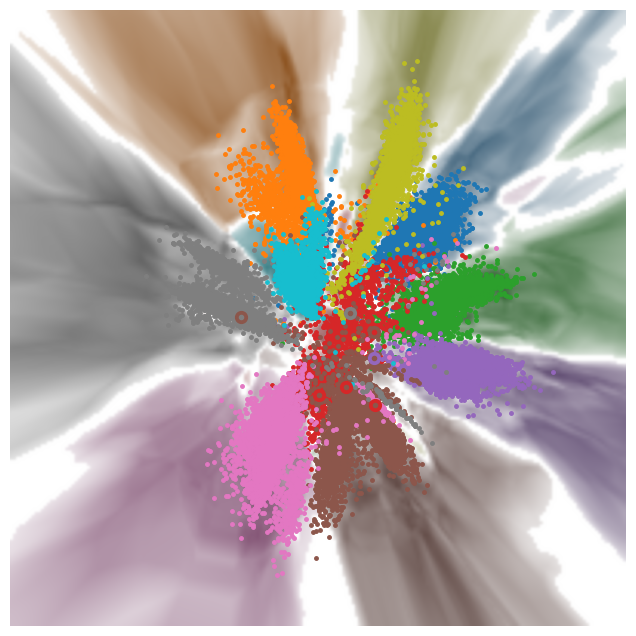

In [142]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, R_n.detach().numpy(),I, np.dot(tar_train_data, S_n.detach().numpy()), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9623.05it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

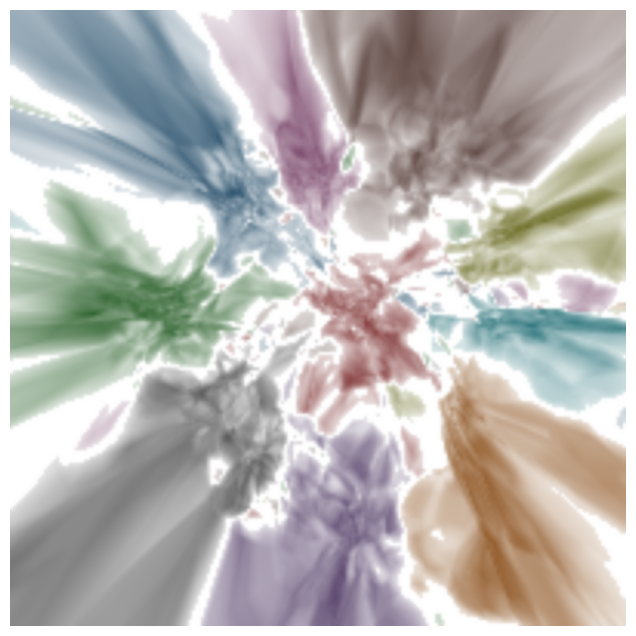

In [149]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis2'

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider,I, I,new_ref_representations, projector, 200,[[]],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 5907.47it/s]


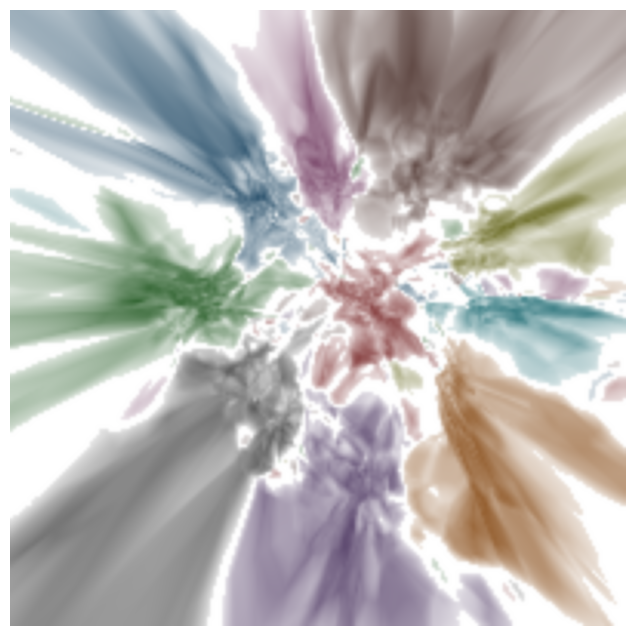

In [150]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis2'

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider,I, I,ref_train_data, projector, 200,[[]],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 13/13 [00:00<00:00, 10637.13it/s]


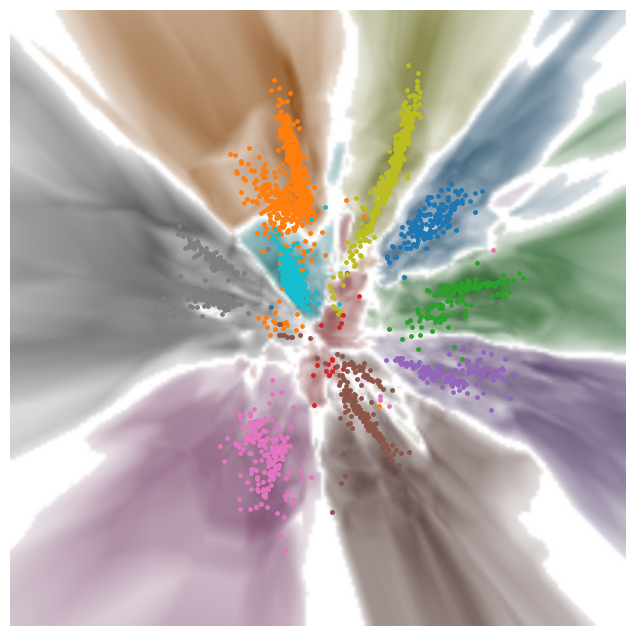

In [139]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, R_n.detach().numpy(),I, np.dot(tar_train_data, S_n.detach().numpy()), projector, 200,[diff_subset],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 13/13 [00:00<00:00, 12534.70it/s]


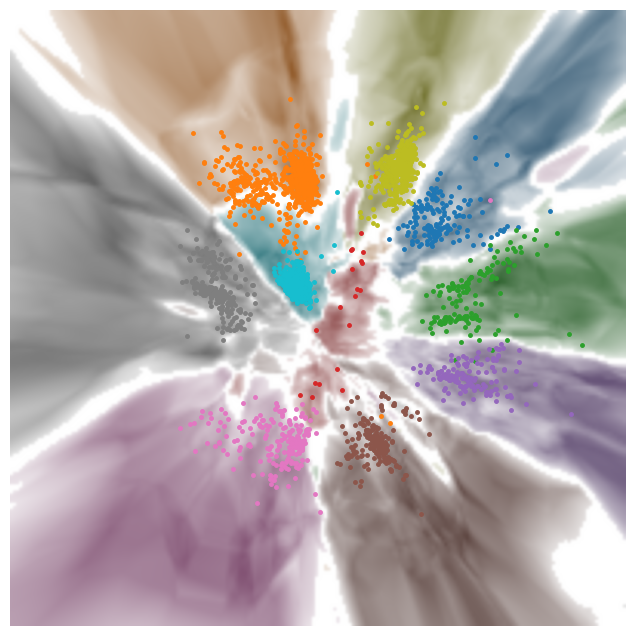

In [137]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(new_ref_representations, I), projector, 200,[diff_subset],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9473.30it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

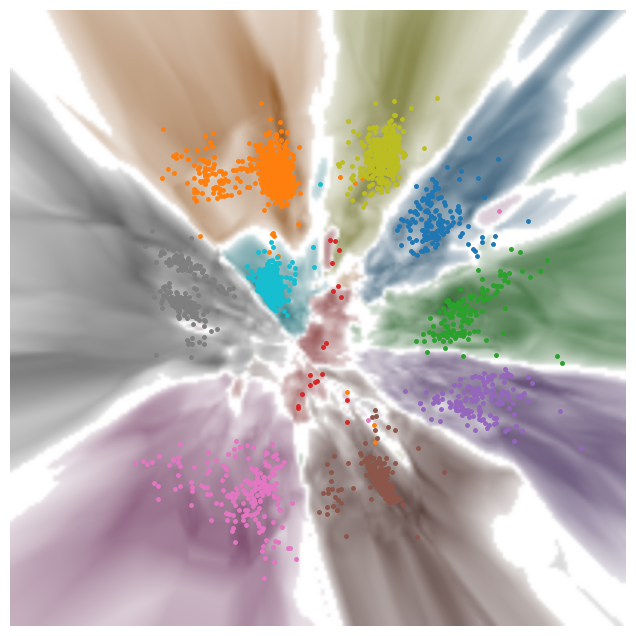

In [103]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_train_data, I), projector, 200,[diff_subset],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

In [154]:
    def getHighDiscrepancyRepresentationSet(X, Y,percentile=95):
        """
            percentile: array_like of float
                Percentile or sequence of percentiles to compute, which must be between 0 and 100 inclusive.

        """
       
        # Perform Procrustes analysis to transform X to Y
        mtx1, mtx2, disparity = procrustes(X, Y)
        # Compute the transformation degree for each row of the matrix
        degree = np.sqrt(np.sum((mtx1 - X)**2, axis=1))

        # Find the subset of samples with the highest transformation degree
        threshold = np.percentile(degree, percentile)
        high_discrepancy_representation_set = np.where(degree > threshold)[0]

        print("Number of samples with highest transformation degree:", len(high_discrepancy_representation_set))

        return high_discrepancy_representation_set

In [151]:
######################### add boundary ########################################

####### generate boundary ponits for tar and ref respectively
from AlignVis.AlignmentBoundaryGenerator import AlignmentBoundaryGenerator
BoundaryGen = AlignmentBoundaryGenerator(REF_PATH,CLEAN_PATH,REF_PATH,CLEAN_PATH,REF_EPOCH,TAR_EPOCH,DEVICE)
ref_boundary,tar_boundary = BoundaryGen.get_boundary_point(DEVICE,num_adv_eg=10000)

NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 7890.20it/s]


NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:01<00:00, 133.08it/s]


data1_index or data2_index is None
conf1 (1540, 10) (4114, 10) (1540, 10) (4114, 10)
conf1 (2, 10) (3, 10) (2, 10) (3, 10)
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (2, 10) (1540, 10) (2, 10) (1540, 10)
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (3, 10) (14, 10) (3, 10) (14, 10)
conf1 (2, 10) (14, 10) (2, 10) (14, 10)
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (1540, 10) (14, 10) (1540, 10) (14, 10)
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (

In [161]:
import torch
###### get border sample features
import torch.nn as nn

ref_feature_model = ref_model.to(DEVICE)
ref_feature_model = nn.Sequential(*list(ref_feature_model.children())[:-1])
with torch.no_grad():
    features = ref_feature_model(ref_boundary)
    ref_features = features.view(ref_boundary.shape[0], -1).cpu().numpy()

In [162]:
###### get border sample features
import torch.nn as nn
tar_feature_model = tar_model.to(DEVICE)
tar_feature_model = nn.Sequential(*list(tar_feature_model.children())[:-1])
with torch.no_grad():
    tar_features = tar_feature_model(tar_boundary)
    tar_features = tar_features.view(tar_boundary.shape[0], -1).cpu().numpy()

In [164]:
dic = getHighDiscrepancyRepresentationSet(ref_features , tar_features  )

Number of samples with highest transformation degree: 500


In [172]:
from AlignVis.ApproximateRepGenerator import ApproximateRefGenerator
aeg_b = ApproximateRefGenerator(ref_provider=ref_provider, tar_provider=tar_provider, REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH, tar_model=tar_model, ref_model=ref_model,DEVICE=DEVICE)

100%|██████████| 250/250 [00:00<00:00, 8457.96it/s]


In [ ]:
newRep_b = aeg_b.generate_representation_by_cka(ref=ref_features[dic], tar=tar_features[dic], epoch=500)

In [175]:
new_ref_representations_b = ref_features
for i in range(len(dic)):
    index = dic[i]
    ref_features[index] = newRep_b[i]

In [177]:
X_for_s = np.concatenate((new_ref_representations,new_ref_representations_b),axis=0)
Y_for_s = np.concatenate((tar_train_data,tar_features),axis=0)

In [178]:
X_for_s.shape

(60000, 512)

In [187]:
S_n_s = alignment_n.align_embeddings_batch(Y_for_s,X_for_s,train_steps=5000,CKA_LAMBDA=10,CKA_LAMBAD_FOR_INIT=1e-8,N_LAMBDA=10)

batch_idx 0,iteration 0, loss1 65516896.0 loss2 {tensor(0.8280, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8600, requires_grad=True)}
batch_idx 199,iteration 199, loss1 597.00341796875 loss2 {tensor(0.5640, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5130, requires_grad=True)}
batch_idx 398,iteration 398, loss1 232.99444580078125 loss2 {tensor(0.4221, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4930, requires_grad=True)}
batch_idx 597,iteration 597, loss1 186.0248260498047 loss2 {tensor(0.5145, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5840, requires_grad=True)}
batch_idx 196,iteration 796, loss1 228.38848876953125 loss2 {tensor(0.4115, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4420, requires_grad=True)}
batch_idx 395,iteration 995, loss1 201.41224670410156 loss2 {tensor(0.3461, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4050, requires_grad=True)}
batch_idx 594,iteration 1194, loss1 161.43743896484375 loss2 {tensor(0.4072, grad_fn=<AddBackward0>)} neibour_

In [193]:
R_n_s = alignment_n.align_embeddings_batch(np.dot(tar_train_data, S_n_s.detach().numpy()),Y_for_s,train_steps=5000,CKA_LAMBDA=10,CKA_LAMBAD_FOR_INIT=1e-8,N_LAMBDA=10)

batch_idx 0,iteration 0, loss1 89805704.0 loss2 {tensor(0.9345, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8920, requires_grad=True)}
batch_idx 199,iteration 199, loss1 266.8535461425781 loss2 {tensor(0.4842, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4390, requires_grad=True)}
batch_idx 398,iteration 398, loss1 179.85638427734375 loss2 {tensor(0.4125, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4170, requires_grad=True)}
batch_idx 97,iteration 597, loss1 187.15541076660156 loss2 {tensor(0.3790, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.3940, requires_grad=True)}
batch_idx 296,iteration 796, loss1 183.4328155517578 loss2 {tensor(0.3459, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.3610, requires_grad=True)}
batch_idx 495,iteration 995, loss1 168.9766387939453 loss2 {tensor(0.3613, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.3720, requires_grad=True)}
batch_idx 194,iteration 1194, loss1 164.39927673339844 loss2 {tensor(0.3329, grad_fn=<AddBackward0>)} neibour_

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8467.05it/s]


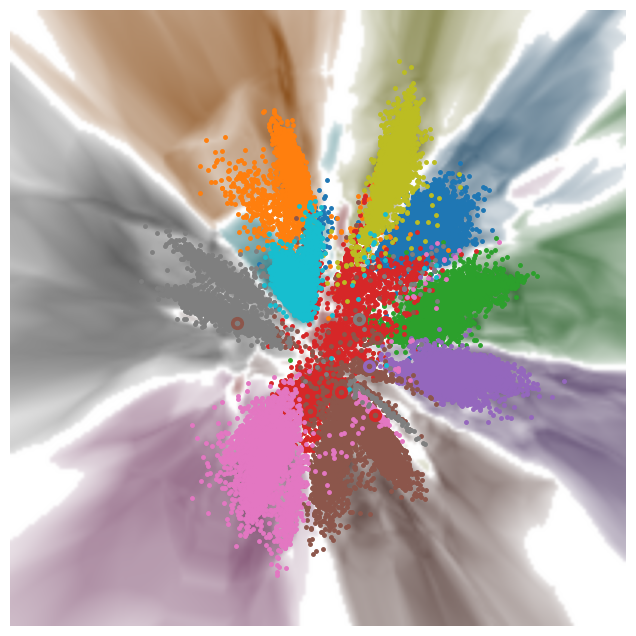

In [194]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, R_n_s.detach().numpy(),I, np.dot(tar_train_data, S_n_s.detach().numpy()), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8336.59it/s]


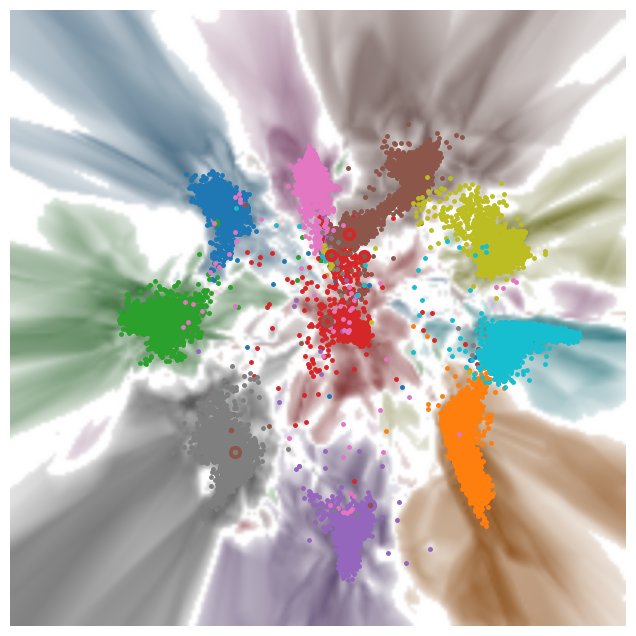

In [196]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis2'

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, R_n_s.detach().numpy(),I, np.dot(tar_train_data, S_n_s.detach().numpy()), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))